In [1]:
from functions import *
import pandas as pd
from pathlib import Path

**Read in the data for table generation**

In [51]:
secretion = pd.read_csv('E:\\blastp_hits\\dl_endo_signalp.txt', sep='\t')

dl_map = pd.read_csv('../../data/clustering/cluster_maps/dl_endopeptidase.tsv', sep='\t')

taxonomy = pd.read_csv('E:\\blastp_hits\\taxonomy_mapping.tsv', sep='\t')

uniref_genome = pd.read_csv('E:\\blastp_hits\\uniref_genome_map.txt', sep='\t', header=None, names=['Genome', 'Uniref'])

# print(secretion.head(), secretion.shape)
# print(dl_map.head(), dl_map.shape)
# print(taxonomy.head(), taxonomy.shape)
# print(uniref_genome.head(), uniref_genome.shape)

In [52]:
# Clean the secretion file to include genome IDs and predicitons

secretion['# ID'] = secretion['# ID'].str.split('#').str[0].str.strip()

secretion['Genome'] = secretion['# ID'].str.split('_').str[0]

secretion = secretion[['# ID', 'Genome', 'Prediction']]

secretion['Genome'] = secretion['Genome'].str.strip('.fa')

# secretion = secretion.rename(columns={'# ID': 'Genome'})

# IDs have extra indicators like this: MGYG000155050_27_22 not found in the mapping file. strip themn off for now 

display(secretion.head()) 

,# ID,Genome,Prediction
0,MGYG000155050_27_22,MGYG000155050,OTHER
1,MGYG000096674_74_7,MGYG000096674,OTHER
2,MGYG000074457_25_259,MGYG000074457,SP
3,MGYG000074457_44_345,MGYG000074457,SP
4,MGYG000002288_3_33,MGYG000002288,SP


In [53]:
# Clean the uniref map add names to columns

uniref_genome.rename(columns={'Genome': '# ID'}, inplace=True)

uniref_genome['# ID'] = uniref_genome['# ID'].str.strip()

# uniref_genome['Genome'] = uniref_genome['# ID'].str.split('_').str[0]

uniref_genome['Uniref'] = uniref_genome['Uniref'].str.split('_').str[1]

display(uniref_genome.head())


,# ID,Uniref
0,MGYG000017941_2_6,A0A1C5WD06
1,MGYG000040828_37_7,A0A1C5LUC3
2,MGYG000089934_88_4,A0A174QFW1
3,MGYG000089934_174_2,A0A1C5LUC3
4,MGYG000097266_6_118,A0A329TNF5


In [54]:
taxonomy['Genome'] = taxonomy['Genome'].str.strip('.fa')

display(taxonomy.head())

,Genome,Lineage
0,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...
1,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...
2,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
3,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...
4,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...


In [55]:
# Merge the secretion data with the uniref map data

secretion_and_uniref = secretion.merge(uniref_genome, on='# ID', how='inner')

display(secretion_and_uniref.head())

,# ID,Genome,Prediction,Uniref
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63


In [56]:
# Merge the secretion and taxonomy data with the uniref_genome data

dle_info = secretion_and_uniref.merge(taxonomy, on='Genome', how='inner')

display(dle_info.head())

,# ID,Genome,Prediction,Uniref,Lineage
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...


In [57]:
print(secretion.shape, secretion_and_uniref.shape, uniref_genome.shape, dle_info.shape)



(75556, 3) (75556, 4) (75556, 2) (75556, 5)


In [58]:
dle_info.isna().sum()

# # ID          0
# Genome        0
# Prediction    0
# Uniref        0
# Lineage       0
# dtype: int64

# ID          0
Genome        0
Prediction    0
Uniref        0
Lineage       0
dtype: int64

In [59]:
# Write this data to a file

dle_info.to_csv('E:\\blastp_hits\\dl_endo_info.tsv', sep='\t', index=False)

In [70]:
display(dl_map.head())

,Unnamed: 0,Uniref,dl_endopeptidase-mmseqs_cluster,dl_endopeptidase-foldseek_cluster
0,0,A0A7S8CCP0,A0A7S8CCP0,A0A7X2Z4H8
1,1,A0A928LPM8,A0A413G4S5,A0A1C5Q6A7
2,2,A0A413G4S5,A0A413G4S5,A0A1C5Q6A7
3,3,A0A926IJ38,A0A413G4S5,A0A1C5Q6A7
4,4,A0A498CNA2,A0A413G4S5,A0A1C5Q6A7


In [71]:
dl_map.rename(columns={'dl_endopeptidase-unclustered': 'Uniref'}, inplace=True)

display(dl_map.head())

,Unnamed: 0,Uniref,dl_endopeptidase-mmseqs_cluster,dl_endopeptidase-foldseek_cluster
0,0,A0A7S8CCP0,A0A7S8CCP0,A0A7X2Z4H8
1,1,A0A928LPM8,A0A413G4S5,A0A1C5Q6A7
2,2,A0A413G4S5,A0A413G4S5,A0A1C5Q6A7
3,3,A0A926IJ38,A0A413G4S5,A0A1C5Q6A7
4,4,A0A498CNA2,A0A413G4S5,A0A1C5Q6A7


In [72]:
filtered_dle_info = dle_info[dle_info['Uniref'].isin(dl_map['Uniref'])]

print(filtered_dle_info.shape)

(74638, 5)


In [76]:
dl_map.to_csv('E:\\blastp_hits\\dl_endo_cluster_map.tsv', sep='\t', index=False)

In [ ]:
protein_info = filtered_dle_info[filtered_dle_info['Uniref'] == 'A0A3S5AQD8']

species = set(protein_info.loc[protein_info['Uniref'] == 'A0A3S5AQD8', 'Lineage'])

display(species, len(species))

**Old Code might re-use**

In [ ]:
# dle_grouped = dle_info.groupby(['Uniref']).agg(list).reset_index()

# print(dle_grouped.shape)

In [ ]:
# dl_and_sec = dl_map.merge(dle_grouped, on='Uniref', how='inner')

# display(dl_and_sec.head())

# print(dl_and_sec.shape)

In [ ]:
# result = dl_and_sec.loc[dl_and_sec['Uniref'] == 'A0A1C5YFQ8', 'Lineage']

# print(len(result))

In [60]:
# dl_and_sec.to_csv('E:\\blastp_hits\\dl_endo_info_grouped.tsv', sep='\t', index=False)

In [126]:
# Now map is created, need to make a function to quickly index clusters and pull important
# information from the table. Get: number species, taxa info, secretion percentage

from collections import Counter

def describe_cluster(cluster_id: str, protein_info_table: Path, cluster_info_table: Path):
    """
    This function takes a cluster ID and a table of information about the clusters and returns
    the number of species, the taxa information, and the percentage of the cluster that is predicted
    to be secreted. 
    """

    # Read in tables as dfs
    cluster_info_table = pd.read_csv(cluster_info_table, sep='\t')
    protein_info_table = pd.read_csv(protein_info_table, sep='\t')

    # given the cluster_id, find the initial uniref IDs and make them into a list
    clustered_dl_list = list(cluster_info_table.loc[cluster_info_table['dl_endopeptidase-foldseek_cluster'] == cluster_id, 'Uniref'])

    # search the protein_info_table for the reuturned Uniref ids. return unique species
    species = list(set(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Lineage']))

    print(species)

    # print(len(species), species)

    # calculate phyla, family and genus percentages
    phyla = []
    family = []
    genus = []
    for index, tax in enumerate(species):
        phyla.append(tax.split(';')[1].replace('p__', ''))
        family.append((tax.split(';')[4]).replace('f__', ''))
        genus.append(tax.split(';')[-2].replace('g__', ''))

    phyla_counts = Counter(phyla)
    family_counts = Counter(family)
    genus_counts = Counter(genus)

    total_species = len(species)
    phyla_percentage = {k: (v / total_species) * 100 for k, v in phyla_counts.items()}
    family_percentage = {k: (v / total_species) * 100 for k, v in family_counts.items()}
    genus_percentage = {k: (v / total_species) * 100 for k, v in genus_counts.items()}
    print(phyla_percentage, family_percentage, genus_percentage)

    # Set the Seaborn style
    sns.set_style('whitegrid')

    # Create a figure to hold the subplots
    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

    # Phyla Distribution
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    plt.pie(phyla_counts.values(), labels=phyla_counts.keys(), autopct='%1.1f%%')
    plt.title('Phyla Distribution')

    # Family Distribution
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    plt.pie(family_counts.values(), labels=family_counts.keys(), autopct='%1.1f%%')
    plt.title('Family Distribution')

    # Genus Distribution
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    plt.pie(genus_counts.values(), labels=genus_counts.keys(), autopct='%1.1f%%')
    plt.title('Genus Distribution')

    # Show the figure with the subplots
    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()
    





    # # taxa_info = cluster_info['Lineage'].unique()
    # # secretion_percentage = (cluster_info['Prediction'] == 'Y').sum() / len(cluster_info)
    # return num_species, # taxa_info, secretion_percentage
  

['d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A;s__Blautia_A massiliensis', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__Blautia sp900539145', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor;s__Acetatifactor sp900066365', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A;s__Blautia_A wexlerae_A', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_A;o__Christensenellales;f__CAG-917;g__CAG-1138;s__CAG-1138 sp000434675', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__Ruminococcus_E;s__Ruminococcus_E sp900314705', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A;s__Blautia_A sp900066505', 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__CAG-590;s__CAG-590 sp000431135', 'd__Bacteria;p__Firmicutes_A;

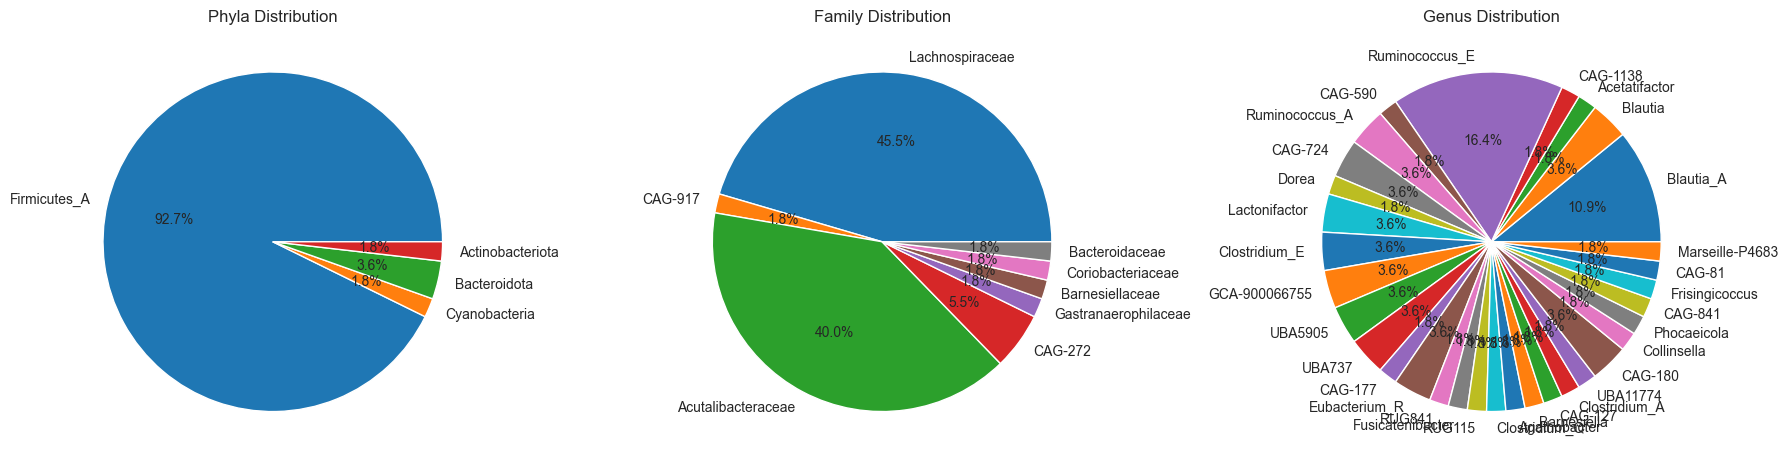

None


In [127]:
print(describe_cluster('A0A1C5Q6A7', 'E:\\blastp_hits\\dl_endo_info.tsv', 'E:\\blastp_hits\\dl_endo_cluster_map.tsv'))

In [13]:
# dl_and_sec.to_csv('dl_and_sec.tsv', sep='\t', index=False)

In [16]:
# Group by the foldseek cluster ID
grouped_data = dl_and_sec.groupby('dl_endopeptidase-foldseek_cluster')

# Initialize a list to hold the statistics for each cluster
cluster_stats = []

# Iterate over each group to calculate statistics
for cluster_id, group in grouped_data:
    total_proteins = group.shape[0]  # Total proteins in the cluster
    secreted_proteins = group[group['Prediction'] == 'SP'].shape[0]  # Proteins predicted as secreted
    percentage_secreted = (secreted_proteins / total_proteins) * 100  # Calculate the percentage
    
    # Append the statistics for this cluster to the list
    cluster_stats.append({
        'Foldseek Cluster ID': cluster_id,
        'Total Proteins': total_proteins,
        'Secreted Proteins': secreted_proteins,
        'Percentage Secreted': percentage_secreted
    })

# Convert the list of statistics into a DataFrame for better visualization
stats_df = pd.DataFrame(cluster_stats)

# Display the statistics DataFrame
stats_df.head()

,Foldseek Cluster ID,Total Proteins,Secreted Proteins,Percentage Secreted
0,A0A077MGS3,4,2,50.0
1,A0A078MK14,3,0,0.0
2,A0A0A2TFV7,3,3,100.0
3,A0A0B0HUJ2,5,0,0.0
4,A0A0D0RVH7,7,7,100.0
